<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (2)</font></h2>

<h1><font color="#00586D" size=5>Análisis y predicción de un conjunto de datos sobre precios de viviendas</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>&copy; Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducción](#section1)
* [2. Preparación de los datos](#section2)
* [3. Exploración preliminar](#section3)

#### <font color="#00586D"> Notebook II</font>
* [4. Predicción con modelos básicos](#section4)
* [5. Ensembles](#section5)
* [6. Explicabilidad](#section6)
* [7. KNN](#section7)
* [8. Construcción de características](#section8)
* [9. Descarte de outliers](#section9)
* [10. Aprendizaje no supervisado: PCA, Manifold y EM](#section10)


---
<br>

En este proyecto se aborda un problema de análisis y predicción de precios de viviendas a partir de un conjunto de datos que se ha obtenido de [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). En la libreta anterior, se preprocesaron estos datos y se hizo una pequeña exploración. El resultado se almacenó en el archivo  `data/houses_prep.csv`. En esta libreta se llevará a cabo el desarrollo del proyecto.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>  A diferencia de proyectos anteriores, en este caso no se trabajará en pasos sucesivos hasta lograr un objetivo, sino que se resolverán ejercicios de distinta índole relacionados con algunas de las técnicas vistas en clase. Por otra parte, **aunque la lectura del proyecto es larga, los ejercicios son cortos** (relativamente 🤓).
</div>


In [2]:
data = pd.read_csv('data/houses_prep.csv', index_col=0, na_values='NA')
#data.info()
data.shape

(1460, 227)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#00586D"> 4. Predicción con modelos básicos</font>
<br>

En este apartado se implementarán unos modelos básicos iniciales sobre los que se trabajará posteriormente para intentar refinar el modelo. A continuación, se crean los conjuntos de datos de entrenamiento y test (33% de los datos). Debido a que el conjunto de datos es pequeño, se utilizará validación cruzada para seleccionar el modelo y determinar los parámetros. 

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='SalePrice').copy()
y = data['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)

(978, 226)
(482, 226)


Para simplificar el código se proporciona una función auxiliar que muestra los resultados de un modelo con respecto a entrenamiento, validación, y test. El parámetro `is_log` permite indicar si se ha pasado el logaritmo de la clase como variable objetivo (veremos después por qué).  Por otra parte, los resultados de los algoritmos se irán almacenando en un *DataFrame* denominado `results` con el fin de que se puedan visualizar fácilmente. Es importante que el nombre del modelo (primer parámetro de la función, `description`) sea representativo y único.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


# DataFrame con los resultados
results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Validación','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
results

def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    val_r2 = cross_val_score(model,X_train,y_train,cv=5).mean()
    test_r2 = model.score(X_test, y_test)
    
    # Si se utiliza el logaritmo de la variable objetivo hay que 
    # convertirlo para calcular el error
    f = np.exp if is_log else lambda y: y
    # Calcula el error    
    train_mae = mean_absolute_error(f(y_train), f(model.predict(X_train)))
    test_mae = mean_absolute_error(f(y_test), f(model.predict(X_test)))
    
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    
    results.loc[description]= (train_r2, val_r2, test_r2, train_mae, test_mae)

---

### <font color="#00586D">Regresión lineal con regularización</font>
<br>



El modelo básico con el que comenzaremos a trabajar es una regresión lineal con regularización L2 (`Ridge()`). 


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 1</font> 

Entrenar un modelo `Ridge()`. Se utilizará `GridSearchCV` (con 5 particiones) para determinar el valor óptimo de `alpha`. El modelo final se almacenará en la variable `ridge`, y se mostrará el resultado con `show_results`.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Para evaluar y comparar modelos **utizaremos, estrictamente,** los resultados de entrenamiento y validación cruzada. El test es informativo, y en ningún momento lo utilizaremos para hacer ajustes.
</div>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression'
show_results(description, ridge, X_train, y_train, X_test, y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.908		R² = 0.846		R² = 0.776
MAE = 15187.84					MAE = 19274.55



Entrenar también un modelo `DecisionTreeRegressor` distintas configuraciones en relación a la profundidad y al número minimo de muestras por hoja. El árbol se almacenará en la variable `tree`. Mostrar los resultados.

In [6]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree'
show_results(description, tree, X_train, y_train, X_test, y_test)

{'max_depth': 5.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.876		R² = 0.715		R² = 0.746
MAE = 20723.77					MAE = 26413.95


El *DataFrame* `results`muestra ambos resultados. Comentarlos (centraos en el $R^2$ en todos los casos).

In [7]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.714649,0.746025,20723.767792,26413.953028


___Comentario___
<br>

`En este caso, el valor de R2 muestra que el resultado obtenido por el modelo de regresión de Ridge son notablemente mejores a los obtenidos por el árbol de regresión. La principal diferencia se observa en un mayor R2 en el caso tanto del conjunto de validación como de test. Lo que es observable en ambos casos es que existe un problema de sobreajuste, ya que el valor de R2 obtenido en el caso del conjunto de entrenamiento es mucho mayor que el obtenido en el conjunto de validación y test. Para paliar este sobreajuste podríamos intentar cambiar otros parámetros o intentar reducir la complejidad del modelo para que no produzca tal sobreajuste.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#00586D"> 5. Ensembles</font>
<br>

Los ensembles, a pesar de su simplicidad (en algunos casos), son una de las técnicas más utilizadas en aprendizaje. El motivo principal es que sobreajustan menos que otros modelos. En este caso, utilizaremos un *Random Forest* para compararlo con los resultados anteriores. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 2</font> 

Entrenar un modelo `RandomForestRegressor`, utilizando validación cruzada para estimar la máxima profundidad. Almacenar el modelo resultante en `rforest` y comentar el resultado.

In [8]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest'
show_results(description, rforest, X_train, y_train, X_test, y_test)

{'max_depth': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.975		R² = 0.855		R² = 0.857
MAE = 7813.42					MAE = 17211.63


In [9]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.714649,0.746025,20723.767792,26413.953028
Random forest,0.975375,0.854910,0.857188,7813.421346,17211.625273


___Comentario___
<br>

`Parece ser que el uso de Random Forest ha mejorado el desempeño del modelo ya que ha aumentado los valores de R2 tanto en el caso del conjunto de entrenamiento, como el de validación y test. Pero pese a ello y pese a conseguir valores en torno al 0,85 en validación y test, la diferencia con respecto a los valores del conjunto de entrenamiento son aún elevadas, sugiriendo que todavía existe cierto sobreajuste en el modelo.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->


Por otra parte, El modelo *Random Forest* obtiene la importancia de las características basándose en la impureza de los árboles (aunque en el artículo original que plantea esta técnica se propone un método basado en permutaciones parecido al que ve en el tema de explicabilidad) y la almacena en el campo `feature_importances_`. A continuación, se obtiene una lista con las (por ejemplo) 20 características más importantes en la predicción y se almacenan en la lista `relevant_feat`. 


In [10]:
relevant_feat = X_train.columns[np.argsort(rforest.feature_importances_)[:-20:-1]].to_list()
print(relevant_feat)

['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'GarageCars', '1stFlrSF', 'LotArea', 'BsmtQual', 'YearBuilt', 'MasVnrArea', '2ndFlrSF', 'OverallCond', 'BsmtUnfSF', 'GarageYrBlt', 'YearRemodAdd', 'KitchenQual', 'MoSold', 'LotFrontage']


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 3</font> 

Volver a entrenar los tres modelos anteriores, pero utilizando solamente las características relevantes (solo cambia que hay que acceder a las columnas al usar los conjuntos de training). Comentar los resultados obtenidos en relación a los obtenidos anteriormente.

In [11]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

ridge_rel = search.best_estimator_
description = 'Ridge regression (Relevant)'
show_results(description, ridge_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.839		R² = 0.825		R² = 0.714
MAE = 20444.04					MAE = 21965.32


In [12]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

tree_rel = search.best_estimator_
description = 'Regression tree (Relevant)'
show_results(description, tree_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 8.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.953		R² = 0.706		R² = 0.802
MAE = 12982.55					MAE = 23764.30


In [13]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

rforest_rel = search.best_estimator_
description = 'Random forest (Relevant)'
show_results(description, rforest_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 20}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.980		R² = 0.848		R² = 0.856
MAE = 6685.41					MAE = 17760.18


In [14]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.714649,0.746025,20723.767792,26413.953028
Random forest,0.975375,0.854910,0.857188,7813.421346,17211.625273
Ridge regression (Relevant),0.839021,0.825211,0.714174,20444.036513,21965.317969
Regression tree (Relevant),0.952867,0.705807,0.802087,12982.552518,23764.297222
Random forest (Relevant),0.980405,0.848169,0.855623,6685.408496,17760.180492


___Comentario___
<br>

`Al repetir los modelos pero esta vez utilizando solamente las variables que parecen más relevantes, vemos que en general el desempeño de los modelos no se ve muy afectado, cosa que era de esperar ya que estas variables deberían codificar la mayor parte de la explicación de la variabilidad de la clase. En el caso de la regresión Ridge, esta es la que se ve algo afectada por la moficación, ya que reduce notablemente su desempeño sobre el conjunto de entrenamiento, lo que ha llevado a un menor sobreajuste de los datos, igualando el R2 obtenido en los conjuntos de validación y entrenamiento, pero se ha empeorado bastante el valor de R2 obtenido para el conjunto de test, mostrando que el modelo puede que este subajustando. En el caso del árbol de regresión, vemos que el cambio no afecta al resultado sobre el conjunto de entrenamiento pero sí que afecta en gran medida a los resultados sobre validación y test. Por útlimo, en el caso de Random forest, los resultados prácticamente no se han visto alterados, cosa que es entendible ya que las variables que se han seleccionado como relevantes se han hecho a partir del primer modelo de Random forest hecho en el ejercicio anterior.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a>
## <font color="#00586D"> 6. Explicabilidad</font>
<br>


En el análisis previo del modelo *Random Forest* hemos visto cuáles son las características más importantes (según la impureza de las mismas [**(+ inf)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). Para hacer una evaluación global de los resultados, nos interesa ver la relación de las variables `OverallQual` y `GrLivArea` con las predicciones obtenidas en el conjunto de test.

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 4</font> 

Dibuja un gráfico de dependencia parcial (PDP) para las variables `OverallQual` y `GrLivArea` (tanto por separado, como de ambas variables juntas). Utiliza el modelo almacenado en `rforest` (entrenado anteriormente) y  `method='brute'` para que el cálculo se realice con la misma aproximación que vista en clase. ¿Cuál es la relación de estas variables con los valores de la salida?

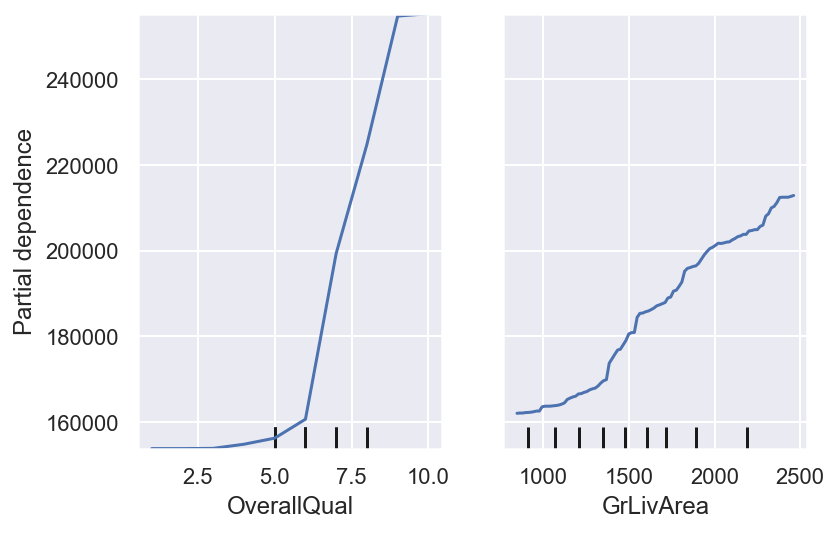

In [15]:
from sklearn.inspection import plot_partial_dependence
features = ["OverallQual", "GrLivArea"]
plot_partial_dependence(rforest, X_train, features, method="brute")
plt.show()

___Comentario___
<br>

`El análisis de las gráficas de dependendia parcial muestra que en el caso de la variable 'OverallQual', a partir de valores mayores que 6 aproximadamente existe una relación lineal fuerte entre la variable y el precio de la vivienda. En el caso de 'GrLivArea' vemos que existe también una relación lineal entre la variable y el precio de la vivienda.`
<br>





<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

El gráfico anterior nos permite visualizar de forma global la relación de las variables con la salida. Imaginemos ahora que nos encontramos en la siguiente situación: una persona quiere poner a la venta su vivienda, pero el precio de venta que predecimos es más bajo del esperado. ¿Podemos explicarle el motivo de dicho resultado?


En este caso, se pretende expicar por qué obtenemos una predicción específica para una muestra específica. En estos casos, podemos utilizar SHAP para estudiar cómo los valores de las distintas variables afectan a la salida.

In [16]:
#!pip install shap

In [17]:
import shap

shap.initjs()

Vamos a estudiar algunas muestras individuales del conjunto de test para simular distintas situaciones. En concreto, vamos a seleccionar las muestras más cercanas a los percentiles 0, 0.25, 0.5, 0.75 y 1 (en cuanto a valor de *y*) en las predicciones del conjunto de test. El 0 corresponderá a la muestra con la predicción de precio más bajo, mientras que 1 sería la muestra de test con la predicción más alta.

In [18]:
y_pred = rforest.predict(X_test)
pcen = np.percentile(y_pred, [0, 25, 50, 75, 100], interpolation='nearest')
i_near = [abs(y_pred - i).argmin() for i in pcen]
samples = X_test.iloc[i_near, :]
samples.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1101,60.0,8400,2,5,1920,1950,0.0,290,0,0,...,0,0,0,1,0,0,0,0,1,0
50,66.0,7742,5,7,1966,1966,0.0,763,0,192,...,0,0,0,1,0,0,0,0,1,0
800,60.0,7200,5,7,1937,1950,252.0,569,0,162,...,0,0,0,1,0,0,0,0,1,0
1356,102.0,10192,7,6,1968,1992,143.0,0,0,570,...,0,0,0,1,0,0,0,0,1,0
1183,160.0,15623,10,5,1996,1996,0.0,2096,0,300,...,0,0,0,1,1,0,0,0,0,0


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 5</font> 

Dibujar los gráficos de fuerzas SHAP para cada una de las 5 muestras seleccionadas. Comentar los resultados.

In [25]:
explainer = shap.TreeExplainer(rforest)
sampleID=samples.index

In [26]:
sample = 0
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [27]:
sample = 1
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [28]:
sample = 2
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [29]:
sample = 3
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [30]:
sample = 4
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

___Comentario___
<br>

`En los gráficos de fuerzas SHAP observamos unos resultados parecidos a los ejercicios anterior, podemos observar que las variables que han tenido más peso en la clasificación en todas las muestras (tanto a la alza como a la baja), han sido OverallQual y GrLivArea, esto demuestra la relevancia de estas variables a la hora de determinar el valor de la casa. Vemos que como era de esperar, cuanto mayor es el valor de estas variables más tiende el modelo a hacer predicciones de valor elevado de la casa, como es el caso de las muestras 3 y 4, por el contrario en las muestras 0, 1 y 2 el reducido valor de OverallQual ha llevado a hacer predicciones más bajas en respecto al precio de la casa.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 6</font> 

Dibuja un resumen global de los valores SHAP de todas las muestras de test con `summary_plot`. Comentar los resultados.

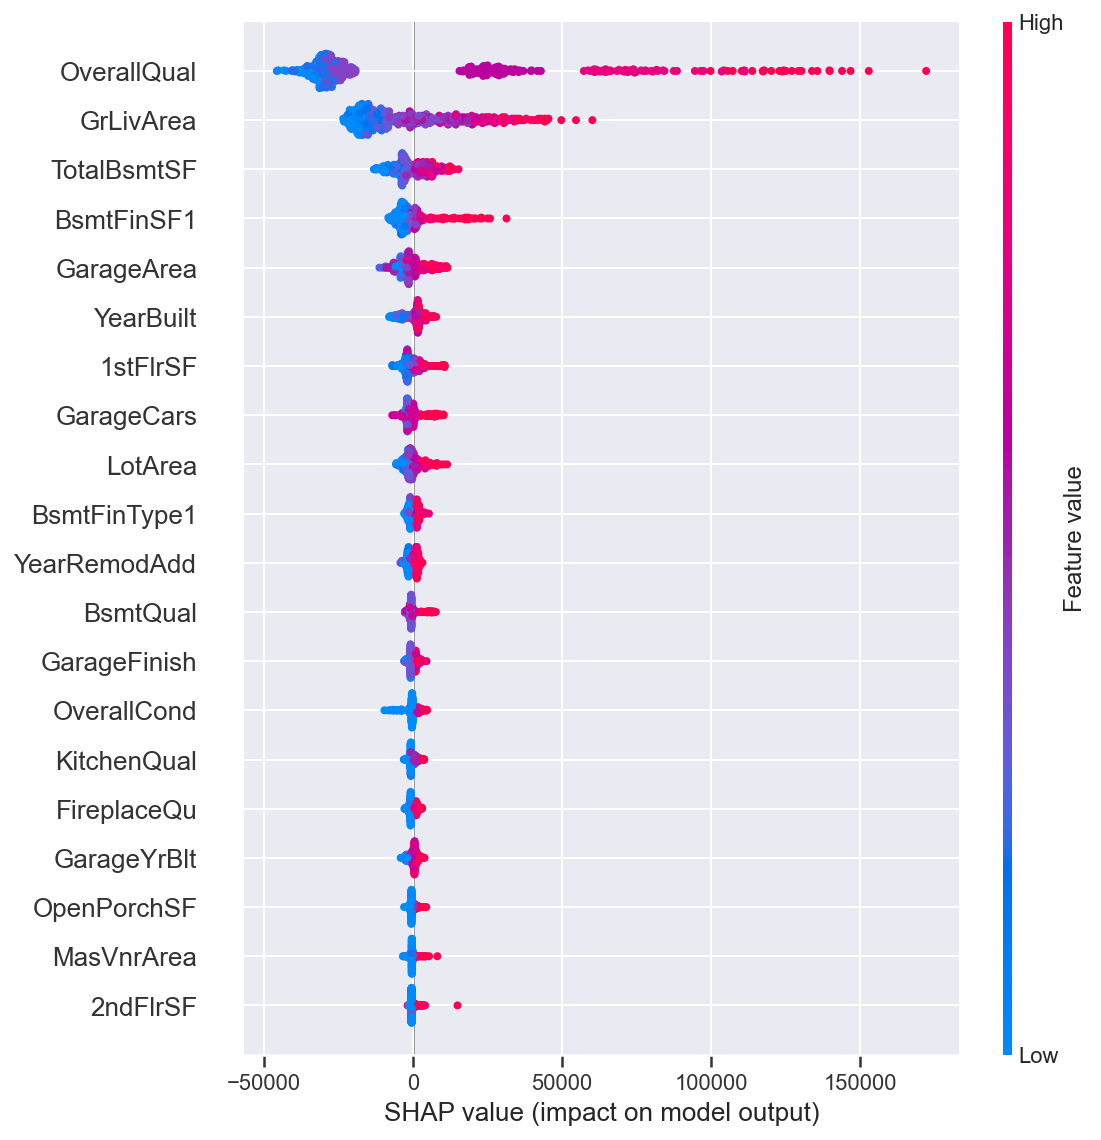

In [33]:
shap.summary_plot(explainer.shap_values(X_test), X_test)

___Comentario___
<br>

`EL resultado nuevamente nos indica la importancia de las variables OverallQual y GrLivArea a la hora de determinar el valor de la casa. Podemos observar que estas variables tienen la capacidad de incidir tanto positivamente como negativamente en el valor de la casa. Otras variables, como por ejemplo OverallCond parecen solo tener cierta importancia a la hora de generar predicciones de valor más reducidas. Esto tiene todo el sentido en este caso, ya que un valor que indique que la condicion en la casa es buena puede no ser muy relevante, pero que la condición de la casa sea mala puede afectar en buena medida al precio. Al contrario otras variables como GarajeCars ocurre lo contrario teniendo importancia a la hora de impulsar una predicción más alta, también entendible ya que puede suponer esta variable que no tenga garaje o que si lo tenga y su tamaño. Pero lo que queda claro con el gráfico es que para casi todas las predicciones, las variables OverallQual y GrLivArea tienen mucha más importancia a la hora de generar la predicción.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a>
## <font color="#00586D"> 7. KNN</font>
<br>

Anteriormente se han usado algunos métodos paramétricos (regresión) y no paramétricos (árboles y *Random Forest*) para la predicción. KNN es otro método no paramétrico muy sencillo.


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 7</font> 

Entrenar un modelo de predicción utilizando el vecino más cercano. Como el conjunto de datos no es excesivamente alto en relación a las características, y este algoritmo es muy sensible a la "*Maldición de la dimensionalidad"*, en esta prueba se utilizarán solamente las características numéricas relevantes obtenidas anteriormente con *Random Forest*, y almacenadas en `relevant_feat` durante el proceso de exploración.  

In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
k=1
knn.set_params(n_neighbors = k)
knn.fit(X_train[relevant_feat], y_train)

description = '1-NN (Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.503		R² = 0.610
MAE = 0.00					MAE = 32802.02


Puede apreciarse que el rendimiento de este algoritmo es muy pobre ($R^2=0.504$ en validación). A continuación se creará un *pipeline* para estandarizar los datos antes de hacer la predicción.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('clas', KNeighborsRegressor())])

pipe_knn.fit(X_train[relevant_feat], y_train)

description = '1-NN (Relevant-STD)'
show_results(description, pipe_knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.875		R² = 0.803		R² = 0.773
MAE = 17295.36					MAE = 21264.16


En este caso, sube de manera sustancial el $R^2$ para el conjunto de validación. ¿Qué sucece?

___Comentario___
<br>

`EN este caso, al utilizar un algoritmo de KNeighbors, que esta basado en las distancias, es muy importante estandarizar las variables, ya que en caso contrario, algunas variables que per se tengan valores más elevados van a tener más peso en el cómputo de las distancias, haciendo que produzcan un sesgo en el modelo que no tiene necesariamente por qué explicar la variabilidad en las muestras. Por eso es mejor realizar un paso de escalado.`
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 8</font> 

Analizar el funcionamiento de KNN con distintos valores para `k`, utilizando pesos uniformes o inversos a la distancia para agregar los valores de los vecinos. En primer lugar, utilizando **todas las variables** (`X_train`) y estandarización.

In [40]:
KNeighborsRegressor().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [42]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, param_grid=parameters, cv=5)
search.fit(X_train, y_train)

print(search.best_params_, end='\n\n')

knn = search.best_estimator_
description = 'k-NN (STD)'
show_results(description, knn, X_train, y_train, X_test, y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.732		R² = 0.698
MAE = 0.00					MAE = 25710.12


Puede hacerse la predicción utilizando solamente las características relevantes obtenidas con `Random Forest` (`relevant_feat`).

In [43]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.810		R² = 0.792
MAE = 0.00					MAE = 20210.55


Comparar y comentar los resultados de ambas pruebas.

___Comentario___
<br>

`Vemos que para ambos casos, los parámetros seleccionados como los mejores son los mismos, por un lado un número de veciones de 10 y pesos basados en las distancias. Podemos observar además que cuando utilizamos solamente las características relevantes obtenidas por Random Forest los valores de validación y test mejoran notablemente, incluso siendo algo mejores que los obtenidos en el ejercicio anterior. Aquí vemos la importancia de la maldición de la dimensionalidad que hace que los clasificadores de este tipo empeoren cuando el número de características es muy elevado.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a>
## <font color="#00586D"> 8. Construcción de características</font>
<br>

La construcción de características puede llevarse a cabo de varias formas. Un enfoque es el que se apoya en una construcción exhaustiva, como por ejemplo se puede hacer con el módulo *Feature Creation* de la librería `feature-engine`[**(+ Inf)**](https://feature-engine.readthedocs.io/en/latest/index.html), seguida de selección; un segundo enfoque se basa en la construcción mediante técnicas más complejas, como la programación genética+autoML; por último, también es posible construir características de manera manual a partir de la exploración. En este proyecto utilizaremos este último enfoque para construir algunas características sencillas. Para ello utilizaremos un conjunto de datos auxiliar, al que denominaremos `data_feat()`.

In [48]:
data_feat = data.copy()

Durante la exploración se observó que la distribución del precio de venta está claramente sesgada. En estos casos, es conveniente trabajar con el logaritmo. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 9</font> 

Calcular el logaritmo de los valores de la columna `data_feat['SalePrice'] `, almacenar el resultado en `data_feat['SalePrice']` y visualizar la distribución con una gráfica de  tipo `histplot`.

In [49]:
data_feat['SalePrice'] = np.log(data_feat['SalePrice'])

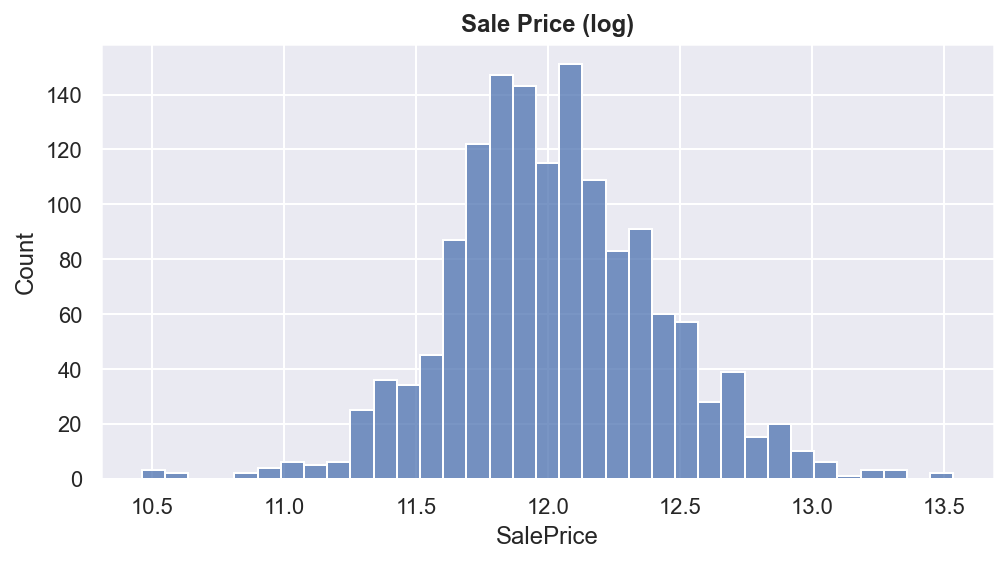

In [59]:
plt.figure(figsize=(8,4))
sns.histplot(data_feat['SalePrice'])
plt.title("Sale Price (log)", fontweight="bold")
plt.show()

También se ha observado que la relación de la variable `OveralQuality`, una de las más correlacionadas, era más fuerte con respecto al logaritmo de la variable `SalesPrice`.

Otra variable imortante, `GrLivArea`, también está sesgada. Sustituirla también por su logaritmo.

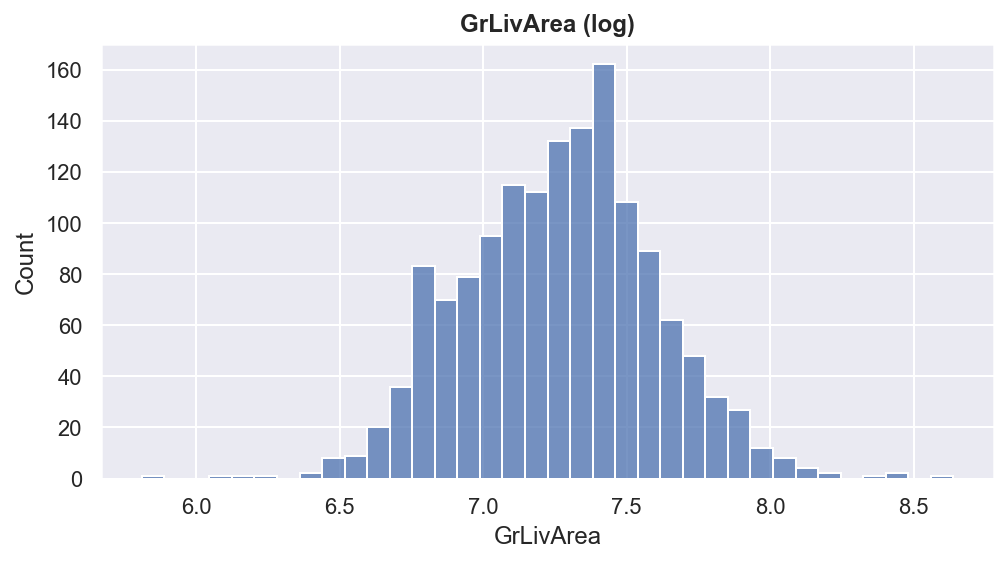

In [60]:
data_feat['GrLivArea'] = np.log(data_feat['GrLivArea'])
plt.figure(figsize=(8,4))
sns.histplot(data_feat['GrLivArea'])
plt.title("GrLivArea (log)", fontweight="bold")
plt.show()

Por último, algunas variables numéricas representan datos temporales. Por ejemplo, en este conjunto de datos, el mes de venta. Aunque su repercursión no es muy fuerte, es conveniente saber tratar estas variables, ya que aparecen a menudo en distintos consumos de datos. A continuación se muestra la distribución de los precios en función del mes. 

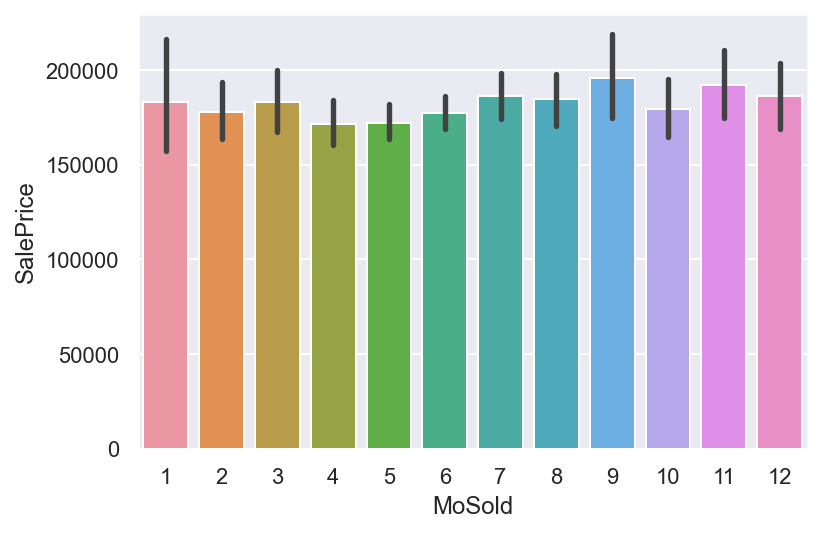

In [61]:
data_feat.sort_values(by='MoSold', inplace=True)
ax = sns.barplot(x=data_feat['MoSold'].astype('str'), y=data['SalePrice']);

Puede observarse que existe cierta oscilación en los precios y que depende del mes. También que el mes 1 y el 12, que representan valores extremos, realmente deberían ser similares, porque se suceden en el tiempo y, además, los precios medios son similares también. Vemos que los precios bajan en mayo y junio, y crecen en septiembre-noviembre. Estas particularidades no se representan mediante una relación lineal, pero se pueden representar mejor con una función sinusoidal.

(1.0, 13.0)

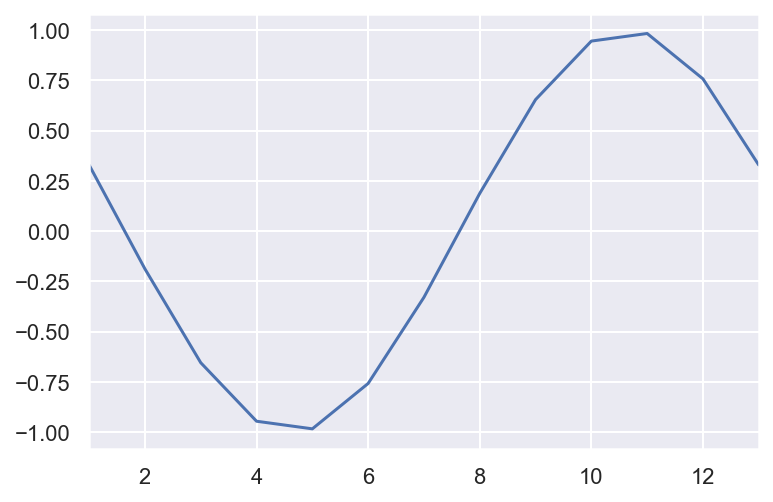

In [62]:
t = np.linspace(1,13, 13, endpoint=True)
ft = np.sin(2*np.pi*t/12-4)

plt.plot(t,ft)
plt.xlim(1,13)

Sustituir los valores de la columna `data_feat['MoSold']` por los obtenidos al calcular la función sinusoidal anterior.

In [66]:
data_feat['MoSold'] = data_feat['MoSold'].map(lambda x: np.sin(2*np.pi*x/12-4))

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

Una vez transformadas las tres variables, se volverán a obtener los conjuntos de entrenamiento y test, ahora con algunas características transformadas.

In [67]:
from sklearn.model_selection import train_test_split

X = data_feat.drop(columns='SalePrice').copy()
y = data_feat['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 10</font> 

Volver a obtener los modelos de regresión lineal y árbol de regresión utilizando los conjuntos de datos obtenidos al transformar las características. Mostrar los resultados (visualizar el *DataFrame* `results`), y comentarlos.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Como la variable `SalePrice` es ahora un logaritmo, es necesario deshacer esa transformación para hacer el MAE. Esto solo implica pasar el argumento `is_log=True` a la función `show_results`. 
<br>

Para KNN, utilizad el *pipeline* para estandarizar los datos, y solo las características incluídas en `relevant_feat`.
</div>

In [68]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT)'
show_results(description, ridge, X_train, y_train, X_test, y_test, True)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.938		R² = 0.900		R² = 0.835
MAE = 12321.07					MAE = 17959.86


In [69]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree (FT)'
show_results(description, tree, X_train, y_train, X_test, y_test, True)

{'max_depth': 12.0, 'min_samples_split': 8}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.980		R² = 0.734		R² = 0.738
MAE = 7192.79					MAE = 25834.78


In [70]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest (FT)'
show_results(description, rforest, X_train, y_train, X_test, y_test, True)

{'max_depth': 15}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.982		R² = 0.864		R² = 0.859
MAE = 6680.75					MAE = 18579.63


In [71]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant - FT)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.832		R² = 0.814
MAE = 0.00					MAE = 0.12


In [72]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.714649,0.746025,20723.767792,26413.953028
Random forest,0.975375,0.854910,0.857188,7813.421346,17211.625273
Ridge regression (Relevant),0.839021,0.825211,0.714174,20444.036513,21965.317969
Regression tree (Relevant),0.952867,0.705807,0.802087,12982.552518,23764.297222
Random forest (Relevant),0.980405,0.848169,0.855623,6685.408496,17760.180492
1-NN (Relevant),1.000000,0.502643,0.609653,0.000000,32802.022822
1-NN (Relevant-STD),0.875446,0.803151,0.773045,17295.361759,21264.161826
k-NN (STD),1.000000,0.732469,0.698286,0.000136,25710.122559


___Comentario___
<br>

`Lo que podemos observar es que en la mayoría de modelos podemos observar cierta mejoría. En el caso de Ridge y kNN la diferencia es más notable y parece ser que para el árbol de regresión y Random Forest el resultado se ve menos afectado.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a>
## <font color="#00586D"> 9. Descarte de outliers</font>
<br>

Llegado a este punto se aprecia que el mejor resultado se ha obtenido con la regresión regularizada (nos basamos en la validación para la selección de modelos), tras transformar algunas características, y utilizando todas las demás.  En algunos casos, los valores anómalos pueden perjudicar al modelo. En regresión, por ejemplo, pueden hacer que algún coeficiente se altere de manera sustancial, sobre todo si el conjunto de datos no es grande.

Por último, se comprobará el efecto de eliminar valores anómalos. 




#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 11</font> 

Utilizar un modelo *Isolation Forest* para "marcar" las muestras que son *outliers*, tanto en el conjunto de entrenamiento como en el conjunto de test. Utilizar una contaminación del 0.5%.  Generar dos vectores (`out_train` y `out_test`) con los resultados (1 para valores normales, y -1 para *outliers*). ¿Cuantos *outliers* hay en el conjunto de entrenamiento? ¿Y en el de test?

In [76]:
from sklearn.ensemble import IsolationForest

iforest =  IsolationForest(n_estimators=100, contamination=0.005)
iforest.fit(X_train)
out_train =  iforest.predict(X_train)
iforest.fit(X_test)
out_test =  iforest.predict(X_test)

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 12</font> 

Eliminar los outliers  de los conjuntos de entrenamiento y test, y entrenar el modelo de regresión lineal regularizada (el mejor modelo hasta el momento). ¿Qué resultados se obtienen?

In [97]:
X_train_out=X_train.loc[[True if x==1 else False for x in out_train]]
y_train_out=y_train.loc[[True if x==1 else False for x in out_train]]
X_test_out=X_test.loc[[True if x==1 else False for x in out_test]]
y_test_out=y_test.loc[[True if x==1 else False for x in out_test]]

In [98]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train_out, y_train_out)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT - No Outliers)'
show_results(description, ridge, X_train_out, y_train_out, X_test_out, y_test_out, True) 

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.947		R² = 0.919		R² = 0.915
MAE = 11565.41					MAE = 14140.58


In [99]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.714649,0.746025,20723.767792,26413.953028
Random forest,0.975375,0.854910,0.857188,7813.421346,17211.625273
Ridge regression (Relevant),0.839021,0.825211,0.714174,20444.036513,21965.317969
Regression tree (Relevant),0.952867,0.705807,0.802087,12982.552518,23764.297222
Random forest (Relevant),0.980405,0.848169,0.855623,6685.408496,17760.180492
1-NN (Relevant),1.000000,0.502643,0.609653,0.000000,32802.022822
1-NN (Relevant-STD),0.875446,0.803151,0.773045,17295.361759,21264.161826
k-NN (STD),1.000000,0.732469,0.698286,0.000136,25710.122559


___Comentario___
<br>

`Vemos que al eliminar los outliers los valores tanto en validación como test han mejorado notablemente, convirtiendose este en el mejor modelo hasta el momento y consiguiendo ya un valor de R2 por encima de 0.9 tanto para validación como para test.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Incorporar este paso al pipeline sería bastante complejo porque no solo modificamos columnas, sino que eliminamos filas. Habría que hacer un *metaclasificador* que primero determine si un valor es un outlier o no, y en función de eso devuelva el resultado (que puede ser -1 para un caso, y la predicción para otro). La implementación de este *pipeline* constituye un ejercicio interesante.
</div>

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section10"></a>
## <font color="#00586D">10. Aprendizaje no supervisado: PCA, Manifold y EM</font>
<br>

Para analizar el conjunto de datos mediante aprendizaje no supervisado se partirá del conjunto de datos original. En este caso trabajaremos solamente con las caracterícticas numéricas más relevantes y el precio.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Estos ejercicios **no son una continuación** de los relacionados con el modelo predictivo, sino que constituyen una estudio independiente. 
</div>

In [110]:
feat = ['OverallQual',
        'GrLivArea',
        'ExterQual',
        'KitchenQual',
        'GarageArea',
        'TotalBsmtSF',
        '1stFlrSF',
        'TotRmsAbvGrd',
        'YearBuilt',
        'SalePrice']

data_small = data[feat]
X_small = data_small.drop(columns='SalePrice').copy()
y_small = data_small['SalePrice'].copy()
data_small.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,SalePrice
Id,,,,,,,,,,
1,7,1710,4,4,548,856,856,8,2003,208500
2,6,1262,3,3,460,1262,1262,6,1976,181500
3,7,1786,4,4,608,920,920,6,2001,223500
4,7,1717,3,4,642,756,961,7,1915,140000
5,8,2198,4,4,836,1145,1145,9,2000,250000


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 13</font>

Utilizar PCA para reducir la dimensionalidad del conjunto de datos `data`. Utilizar dos componentes y almacenar la proyección en una variable denominada `data_pc`. Mostrar la proporción de varianza mostrada por cada componente. Dibujar una gráfica de dispersión con los valores de las dos primeras características creadas (proyecciones correspondientes a las dos componentes). ¿Qué se observa? (Se puede utilizar como color, por ejemplo, `hue=data['SalePrice']`).

In [132]:
from sklearn.decomposition import PCA

pca =  PCA(n_components=2)
pca.fit(X_small)
data_pc = pca.transform(X_small) 

print(f'Número de componentes: {data_pc.shape[1]}')

Número de componentes: 2


In [133]:
df_pca=pd.DataFrame(data_pc, columns=["PC1", "PC2"], index=data_small.index)

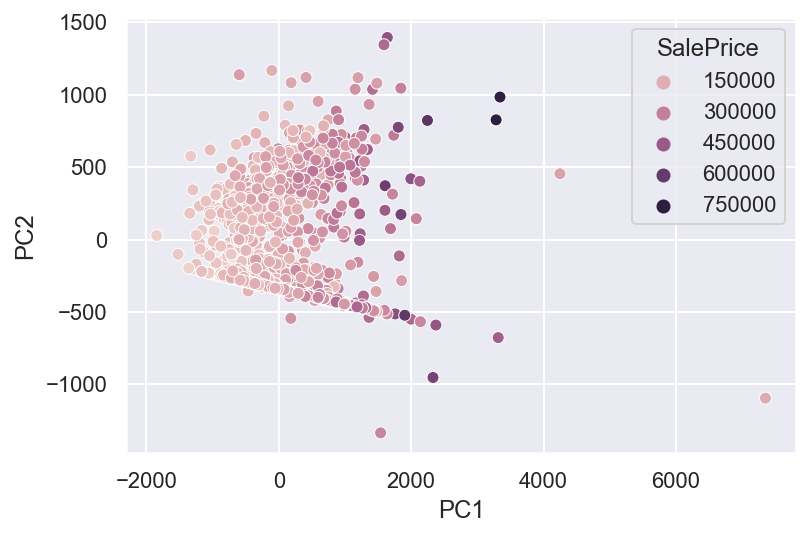

In [134]:
sns.scatterplot(x = "PC1", y = "PC2", data = df_pca, hue=data['SalePrice']);

Muestra las cargas de las dos componentes (los 5 valores más importantes)

In [135]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.653562745572474),
 ('TotalBsmtSF', 0.5370383674884146),
 ('1stFlrSF', 0.4985930620587334),
 ('GarageArea', 0.18871618167276533),
 ('YearBuilt', 0.015235163951238067)]

In [136]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.739118435164753),
 ('TotRmsAbvGrd', 0.0022428157456643037),
 ('OverallQual', 0.00028672687880801747),
 ('KitchenQual', 3.873424943778999e-06),
 ('ExterQual', -1.7891950633232528e-05)]

___Comentario___
<br>

`Vemos que la componente 1 es la que explica mejor las diferencias en el precio de la casa, la componente dos no parece haber tenido tanta relevancia en ese aspecto. Vemos que la carga de la primera componente influye en gran medida GrLivArea, TotalBsmtSF y 1stFlrSF. En cambio en la segunda componente, practicamente la carga es casi exclusivamente para la variable GrLivArea.`
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 14</font>




Construir un *pipeline* en el que el primer paso consista en escalar las características a media cero y desviación uno mediante un objeto `StandardScaler`, y después se  repita el proceso anterior, almacenando la proyección de los datos en `data_pc`. Mostrar el número de componentes necesarias para retener el 99% de la varianza de los datos. ¿Son ahora tan relevantes las dos primeras componentes? ¿Por qué? ¿Cuánta varianza acumulan? ¿Podrían interpretarse de algún modo?

In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipe_sc_pca = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA())])
pipe_sc_pca.fit(X_small)
data_pc = pipe_sc_pca.transform(X_small)

print(f'Número de componentes: {data_pc.shape[1]}')

Número de componentes: 9


In [145]:
print('Varianza explicada:', pipe_sc_pca.named_steps['pca'].explained_variance_)  
print('Varianza explicada ratio:', pipe_sc_pca.named_steps['pca'].explained_variance_ratio_)
print('Varianza explicada acumulada:', np.cumsum(pipe_sc_pca.named_steps['pca'].explained_variance_ratio_))

Varianza explicada: [4.85514152 1.38596897 0.95076011 0.54946623 0.42438759 0.29539471
 0.25163734 0.16057043 0.1328417 ]
Varianza explicada ratio: [0.53909068 0.15389108 0.10556766 0.06100999 0.04712188 0.03279915
 0.02794055 0.01782894 0.01475008]
Varianza explicada acumulada: [0.53909068 0.69298175 0.79854941 0.85955939 0.90668127 0.93948043
 0.96742098 0.98524992 1.        ]


Resultados del PCA anterior

In [148]:
print('Varianza explicada:', pca.explained_variance_)  
print('Varianza explicada ratio:', pca.explained_variance_ratio_)
print('Varianza explicada acumulada:', np.cumsum(pca.explained_variance_ratio_))

Varianza explicada: [465306.17343722 140280.27267401]
Varianza explicada ratio: [0.70005369 0.21105184]
Varianza explicada acumulada: [0.70005369 0.91110553]


In [146]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.6535627455724742),
 ('TotalBsmtSF', 0.5370383674884144),
 ('1stFlrSF', 0.4985930620587333),
 ('GarageArea', 0.1887161816727652),
 ('YearBuilt', 0.015235163951238063)]

In [147]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.7391184351647528),
 ('TotRmsAbvGrd', 0.0022428157456643033),
 ('OverallQual', 0.0002867268788080153),
 ('KitchenQual', 3.8734249437803e-06),
 ('ExterQual', -1.7891950633399062e-05)]

___Comentario___
<br>

`Para retener una varianza del 99% deberíamos retener 10 componentes, que es igual que el número de variables inicial. Vemos que ahora las dos primeras componentes solo explican el 69% de la varianza, al contrario que en el ejercicio anterior donde explicaban el 91%, ahora estas dos primeras componentes son menos importantes y necesitamos un mayor número de variables para explicar la varianza. Esto puede deberse a la ausencia de estandarización en el primer análisis de PCA, ya que como las diferentes variables tienen diferentes escalas, con un par de variables que capten la varianza de las variables que mayores valores puedan llegar a tomar podría llevar a que el análisis muestre que es capaz de explicar gran parte de la varianza con pocas componentes. Por ello es importante realizar el escalado, para que se intente explicar la varianza de todas las variables.`
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 15</font>

Repetir el ejercicio anterior, pero utilizando ahora TSNE. Para ello, crear un *pipeline* en el que el primer paso corresponda a la estadarización, y el segundo a un modelo TSNE en el que `n_components=2`. Utilizarlo para transformar los datos en `data_small` y almacenar el resultado en un array denominado `data_vis`.

In [162]:
from sklearn.manifold import TSNE

pipe_sc_tsne = Pipeline([('scaler', StandardScaler()),
                    ('TSNE', TSNE(n_components=2))])
data_vis = pipe_sc_tsne.fit_transform(X_small)

print(f'Número de componentes: {data_vis.shape[1]}')

Número de componentes: 2


Elaborar una gráfica de dispersión con los datos de `data_vis`.

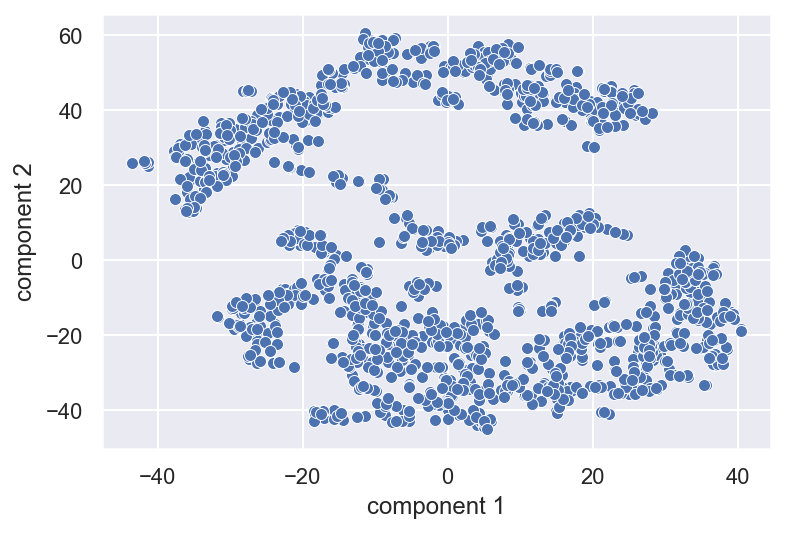

In [163]:
df_tsne=pd.DataFrame(data_vis, columns=["component 1", "component 2"], index=data_small.index)
sns.scatterplot(x = "component 1", y = "component 2", data = df_tsne);

Repetir la gráfica, pero utilizando `hue=data['SalePrice']` 

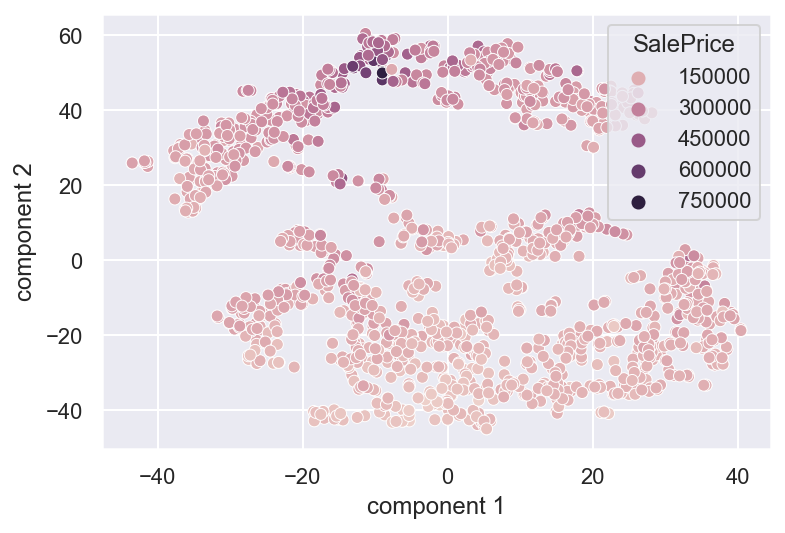

In [164]:
sns.scatterplot(x = "component 1", y = "component 2", data = df_tsne, hue=data_small['SalePrice']);

Probar a utilizar el color para mostrar otra variables, como por ejemplo `YearBuilt`.

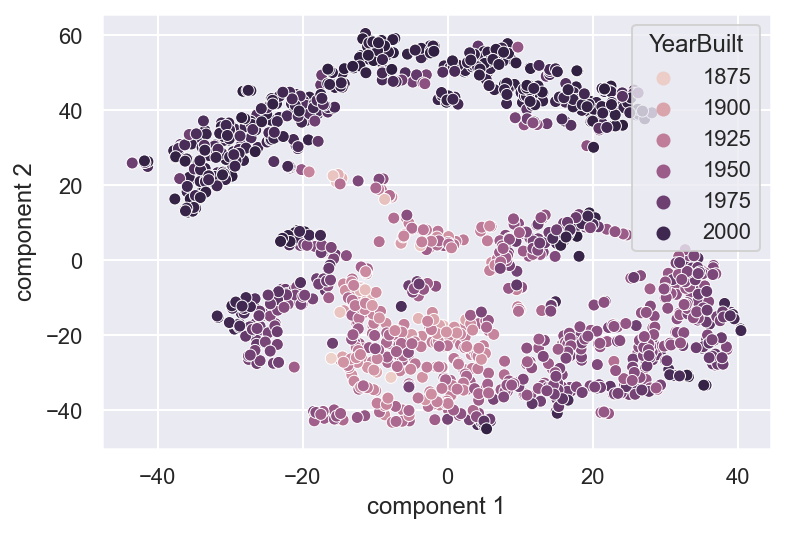

In [165]:
sns.scatterplot(x = "component 1", y = "component 2", data = df_tsne, hue=data_small['YearBuilt']);

___Comentario___
<br>

`En el caso de TSNE vemos que ahora ambas componentes tienen importancia para explicar los precios de las casas, el gráfico de dispersión genera un grupo separado claramente del resto, pero esto no se relaciona directamente con un mayor o menor precio de las casas, parece ser que este es el grupo de las casas más modernas o que han sido contruidas hace menor tiempo.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 16</font>

Por último, se va a utilizar el algoritmo EM (modelo `GaussianMixture`) para representar la distribución de las viviendas que hay en `data_small`, y utilizando `n_components=2`.   En este caso, también es necesario utilizar un *pipeline* en el que el primer paso consista en una estandarización, y el segundo el propio algoritmo. Almacenar el cluster al que pertenece cada vivienda en `cluster`.

In [166]:
from sklearn.mixture import GaussianMixture

pipe_sc_gm = Pipeline([('scaler', StandardScaler()),
                    ('GM', GaussianMixture(n_components=2))])
cluster = pipe_sc_gm.fit_predict(X_small)

Obtener la media de todas las columnas para cada uno de los grupos y compararlos. ¿Puede hacerse algún tipo de interpretación?

In [173]:
data_small["group"]=cluster
data_small.groupby("group").mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,SalePrice
group,,,,,,,,,,
0,7.241877,1774.862816,4.043321,4.057762,594.680505,1276.377256,1317.236462,7.021661,1994.01444,240743.169675
1,5.400662,1356.846578,3.000000,3.177704,398.562914,923.547461,1068.086093,6.209713,1957.35872,144341.313466


Otra forma de interpretar los clusters es mediante visualización. Mostrar una gráfica de dispersión con las columnas `GrLivArea` y `SalePrice`. Utilizar  `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

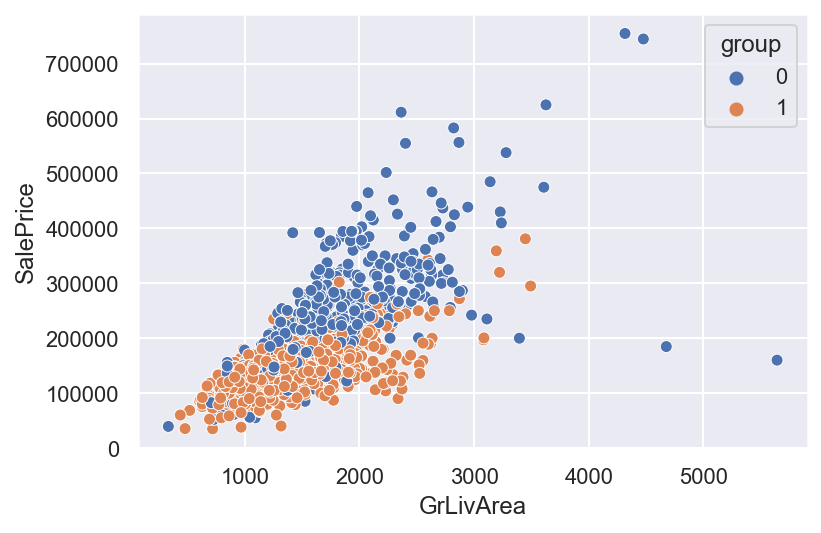

In [177]:
sns.scatterplot(x="GrLivArea", y="SalePrice", data=data_small, hue="group");

Elaborar ahora una gráfica de dispersión, pero con los datos de `data_pc`, utilizando otra vez `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

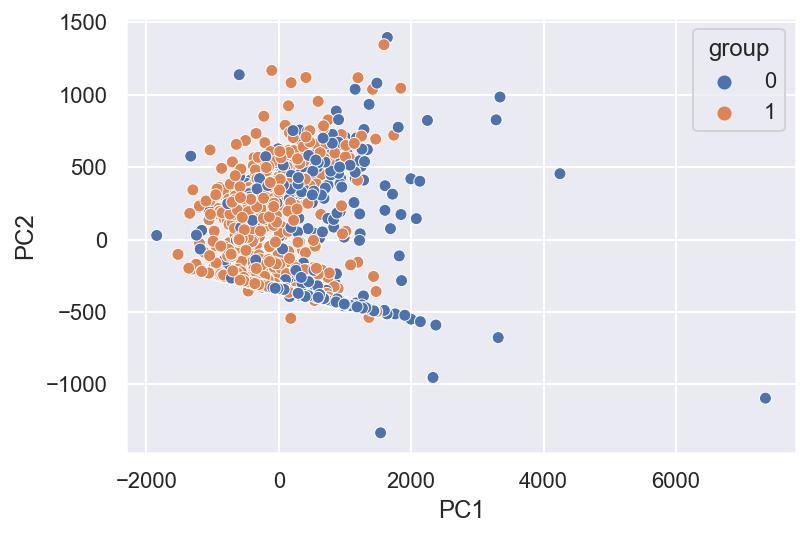

In [178]:
df_pca["group"]=cluster
sns.scatterplot(x="PC1", y="PC2", data=df_pca, hue="group")

Repetir la gráfica, pero con los datos en `data_vis`. ¿Puede hacerse algún tipo de interpretación? 

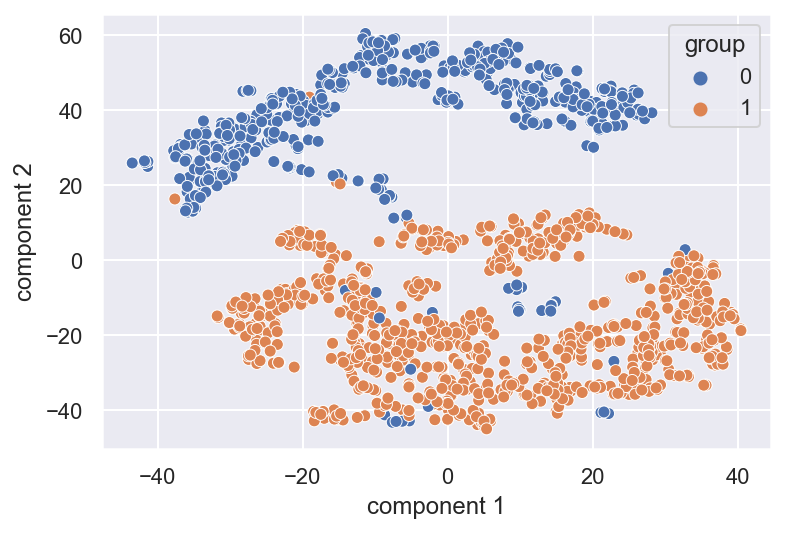

In [180]:
df_tsne["group"]=cluster
sns.scatterplot(x="component 1", y="component 2", data=df_tsne, hue="group");

___Comentario___
<br>

`Lo que podemos observar por la distribución de las medias y el gráfico de dispersoón para cada uno de los cluster es que el grupo 0 corresponde con casas más nuevas y que en general tienen un mayor precio de venta, además de que presentan mejores puntuaciones en casi todas las variables que se han considerado como importantes. Vemos que al hacer esta separación por grupos obtenemos unas conclusiones similares a las que habíamos obtenido anteriormente. En el caso del análisis por PCA, la componente 1 es la que mejor explica las diferencias de precio y podemos ver como el grupo 0 (el característico por ser casas más nuevas y mejor valoradas) parece agrupar y ser más predominante para valores elevados de esta componente. En el caso de TSNE, vemos que las casas más nuevas y mejor valoradas agrupan y forman un cluster diferenciado del resto, tal y como habíamos descrito al analizar el resultado por TSNE, en este caso vemos que esas corresponden al grupo 0 del análisis por GaussianMixture.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>